In [8]:
import pandas as pd
import os.path

data = pd.read_csv(os.getcwd() + '/steam_games.csv')
print(len(data))
list(data.columns)


40833


['url',
 'types',
 'name',
 'desc_snippet',
 'recent_reviews',
 'all_reviews',
 'release_date',
 'developer',
 'publisher',
 'popular_tags',
 'game_details',
 'languages',
 'achievements',
 'genre',
 'game_description',
 'mature_content',
 'minimum_requirements',
 'recommended_requirements',
 'original_price',
 'discount_price']

In [9]:
data = data[data['name'].str.contains('', na=False)]
data['genre'] = data['genre'].fillna('Other')
data = data[~data['genre'].str.contains('Sexual')]
data = data[~data['genre'].str.contains('Nudity')]
data['all_reviews'] = data['all_reviews'].fillna('Mixed')
data['genre'] = data['genre'].fillna('Other')

def check_tuple(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 4
    elif 'very positive' in tuple_value.lower():
        return 3
    elif 'mostly positive' in tuple_value.lower():
        return 1
    elif 'mixed' in tuple_value.lower():
        return 0
    elif 'overwhelmingly negative' in tuple_value.lower():
        return -4
    elif 'very negative' in tuple_value.lower():
        return -3
    elif 'mostly negative' in tuple_value.lower():
        return -1
    elif 'negative' in tuple_value.lower():
        return -2
    elif 'positive' in tuple_value.lower():
        return 2
    else:
        return 0
      
def check_tuple2(tuple_value):
    if 'overhwelmingly positive' in tuple_value.lower():
        return 'Overhwelmingly Positive'
    elif 'very positive' in tuple_value.lower():
        return 'Very Positive'
    elif 'mostly positive' in tuple_value.lower():
        return 'Mostly Positive'
    elif 'mixed' in tuple_value.lower():
        return 'Mixed'
    elif 'overwhelmingly negative' in tuple_value.lower():
        return 'Overwhelmingly Negative'
    elif 'very negative' in tuple_value.lower():
        return 'Very Negative'
    elif 'mostly negative' in tuple_value.lower():
        return 'Mostly Negative'
    elif 'negative' in tuple_value.lower():
        return 'Negative'
    elif 'positive' in tuple_value.lower():
        return 'Positive'
    else:
        return 'Mixed'
      

data['review_scores'] = data['all_reviews']
data['review_scores'] = data['review_scores'].apply(check_tuple)
data['all_reviews'] = data['all_reviews'].apply(check_tuple2)
data.drop(['url', 'types', 'recent_reviews', 'achievements', 'original_price', 'recommended_requirements', 'discount_price', 'minimum_requirements', 'mature_content', 'game_description'], axis=1, inplace=True)

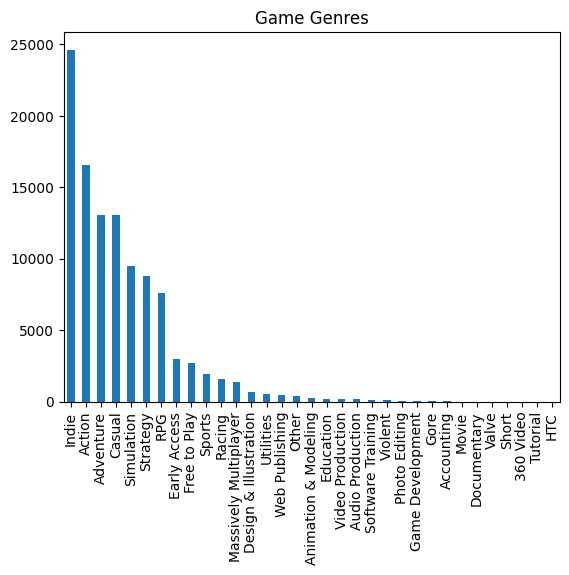

In [10]:
import matplotlib.pyplot as plt

data['genre'] = data['genre'].str.split(',')
data_exploded = data.explode('genre')

counts = data_exploded['genre'].value_counts()

# Create a pie chart
ax = counts.plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Game Genres')
plt.show()

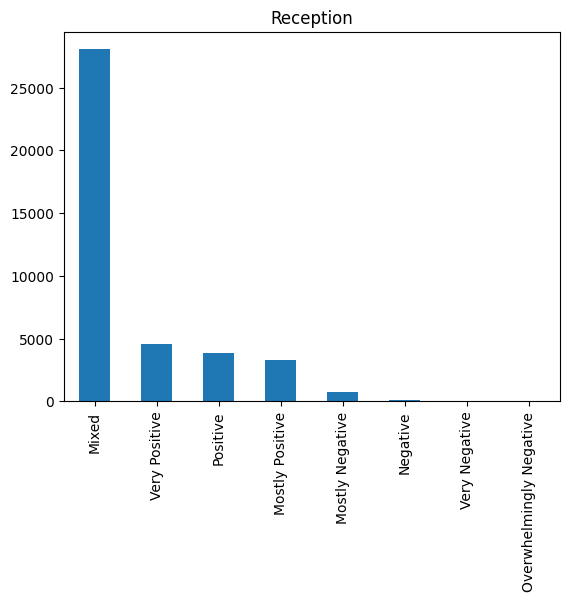

In [11]:
import matplotlib.pyplot as plt


# Create a pie chart
ax = data['all_reviews'].value_counts().plot(kind='bar', legend=False)

# Add some formatting
ax.set_ylabel('')
ax.set_title('Reception')
plt.show()